In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import halfnorm

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform

from MINOV.density import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.ticker as ticker
from style import mpl_style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Supplementary Material A
Here we show that in the absence of gaps, the weight function approximates the constituent distributions from which a dataset was drawn.

In [8]:

def set_blob_params(bottom_pos=0.0):

    blob_params = [
        # {"center": [0.6, 0.6], "std": 0.1, "random_state": 10},
        # {"center": [-1.5, -1.5], "std": 0.1, "random_state": 10},
        {"center": [bottom_pos, bottom_pos], "std": 0.1, "random_state": 10},
        {"center": [1, 1], "std": 0.3, "random_state": 5},
        {"center": [2, 2], "std": 0.5, "random_state": 6},
        {"center": [2, 1], "std": 0.1, "random_state": 11},
    ]

    return blob_params


# Generate all blobs and concatenate
def get_X(blob_params):

    X = np.vstack(
        [
            make_blobs(
                n_samples=20,
                centers=[params["center"]],
                cluster_std=params["std"],
                random_state=params["random_state"],
            )[0]
            for params in blob_params
        ]
    )

    return X

sigmas = [0.1, 0.3, 0.5, 0.1]

# Create x values
x_pdf = np.linspace(0, 1.5, 200)

# Initialize sum of PDFs
pdf_sum = np.zeros_like(x_pdf)

# Plot each distribution and add to sum
for i, sigma in enumerate(sigmas):
    pdf = halfnorm.pdf(x_pdf, scale=sigma)
    pdf_sum += pdf/np.max(pdf)

pdf_sum = pdf_sum / len(sigmas)
pdf_sum /= np.max(pdf_sum)


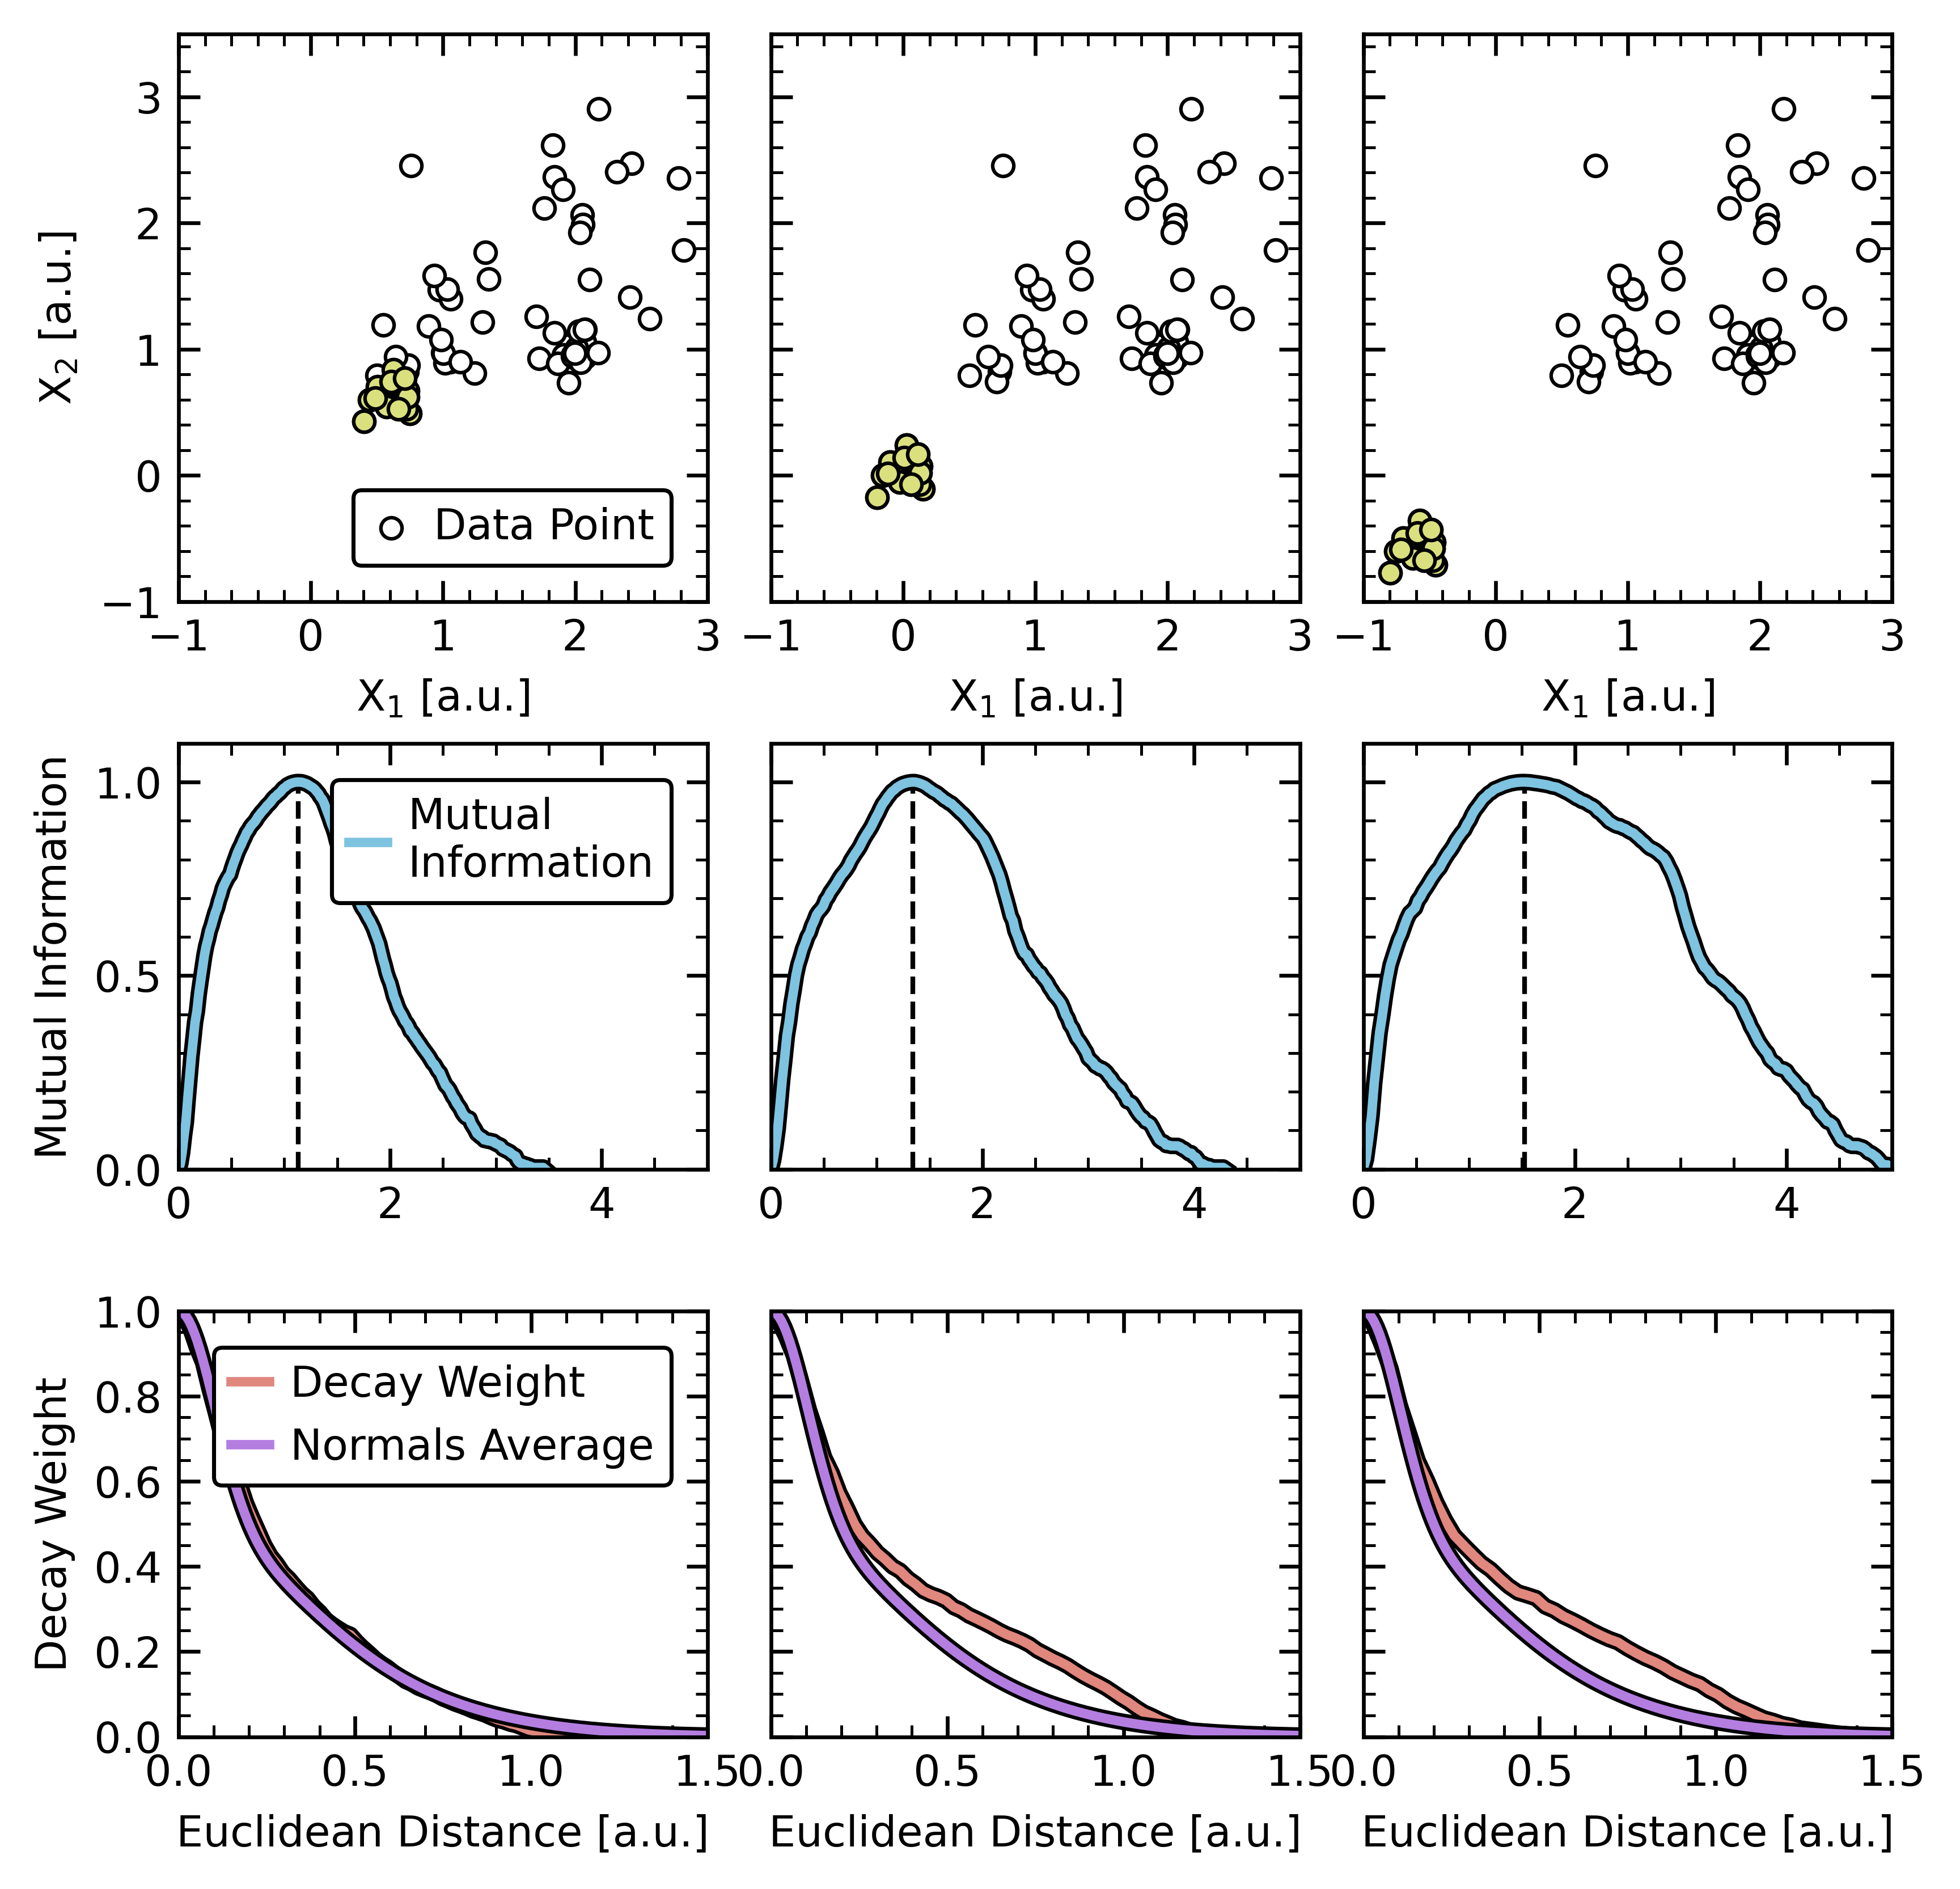

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6.5, 6.5), dpi=600, height_ratios=[1, 0.75, 0.75])

# set hspace and wspace
fig.subplots_adjust(hspace=0.3, wspace=0.12)

for i, pos in enumerate([0.6, 0.0, -0.6]):
    blob_params = set_blob_params(pos)
    X = get_X(blob_params)
    X_dm = squareform(pdist(X, metric="euclidean"))

    # Create the scatter plot
    ax[0, i].scatter(X[:, 0], X[:, 1], s=20,lw=0.75, fc='w', ec='k')
    ax[0, i].scatter(X[:20, 0], X[:20, 1], s=20, lw=0.75, fc='#DAE07E', ec='k')
    ax[0,i].set_ylim(-1.0, 3.5)
    ax[0,i].set_xlim(-1.0, 3)
    ax[0,i].set_xticks([-1, 0, 1, 2, 3])
    ax[0,i].set_xlabel("X$_1$ [a.u.]")

    num_thresh = 200
    cutoff, mi_profile = get_MI_profile(X_dm, num_thresh)
    minov_dens, weight_function = compute_MI_density(X_dm, cutoff, mi_profile)
    minov_dens = minov_dens / minov_dens.max()  # normalize to [0, 1] for colorbar

    # set to zero after cutoff
    mask = np.linspace(0, np.max(X_dm), num_thresh) <= cutoff

    x = np.linspace(0, np.max(X_dm), num_thresh)[mask]
    y = 1-mi_profile[mask]/mi_profile[mask].max()

    ax[1, i].vlines(cutoff, 0, 1, lw=1, color="k", ls="--")
    ax[1, i].plot(np.linspace(0, np.max(X_dm), num_thresh), mi_profile, lw=3.5, color="k")
    ax[1, i].plot(np.linspace(0, np.max(X_dm), num_thresh), mi_profile/np.max(mi_profile), color="#7EC3E0", lw=2)
    ax[1,i].set_ylim(0.0, 1.1)
    ax[1, i].set_yticks([0.0, 0.5, 1.0])
    ax[1,i].set_xlim(0.0, 5)
    ax[1, i].set_xticks([0, 2, 4])

    ax[2,i].plot(np.linspace(0, np.max(X_dm), num_thresh)[mask], (1-(mi_profile/np.max(mi_profile))[mask]), lw=3.5, color="k", zorder=1)
    ax[2,i].plot(np.linspace(0, np.max(X_dm), num_thresh)[mask], (1-(mi_profile/np.max(mi_profile))[mask]), lw=2, color="#E0877E", zorder=2)
    ax[2,i].plot(x_pdf, pdf_sum, lw=3.5, color="k")
    ax[2,i].plot(x_pdf, pdf_sum, lw=2, color="#B47EE0")
    ax[2,i].set_ylim(0.0, 1.0)
    ax[2,i].set_xlim(0.0, 1.5)
    ax[2,i].set_xlabel("Euclidean Distance [a.u.]")

    if i == 0:
        ax[0, i].set_ylabel("X$_2$ [a.u.]")
        ax[1, i].set_ylabel("Mutual Information")
        ax[2, i].set_ylabel("Decay Weight")

    if i > 0:
        ax[0,i].set_yticklabels([])
        ax[1,i].set_yticklabels([])
        ax[2,i].set_yticklabels([])


ax[0,0].scatter([],[], s=20, lw=0.75, fc='w', ec='k', label='Data Point')
legend = ax[0,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='lower right')
legend.get_frame().set_linewidth(0.85)

ax[1,0].plot([],[], color='#7EC3E0', label='Mutual\nInformation')
legend = ax[1,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='upper right', handlelength=0.9)
legend.get_frame().set_linewidth(0.85)

ax[2,0].plot([],[], color='#E0877E', label='Decay Weight')
ax[2,0].plot([],[], color='#B47EE0', label='Normals Average')
legend = ax[2,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='upper right', handlelength=0.9)
legend.get_frame().set_linewidth(0.85)

plt.show()

### Supplementary Material B

Here we show the behavior of the method when analyzing a discrete grid of points.

In [10]:
# Create a grid with evenly spaced points
n_points = 80
grid_size = int(np.sqrt(n_points))

# Create evenly spaced points in a grid pattern
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Flatten to get individual points
X = np.vstack([X.flatten()[:n_points], Y.flatten()[:n_points]]).T

X_dm = squareform(pdist(X, metric="euclidean"))

In [11]:
cutoff, mi_profile = get_MI_profile(X_dm, 200)
print("cutoff", cutoff)
minov_dens, weight_function = compute_MI_density(X_dm, cutoff, mi_profile)

minov_dens = minov_dens / minov_dens.max() # normalize densities

# set to zero after cutoff
mask = np.linspace(0, np.max(X_dm), 200) <= cutoff
x = np.linspace(0, np.max(X_dm), 200)

cutoff 0.5898478677234518


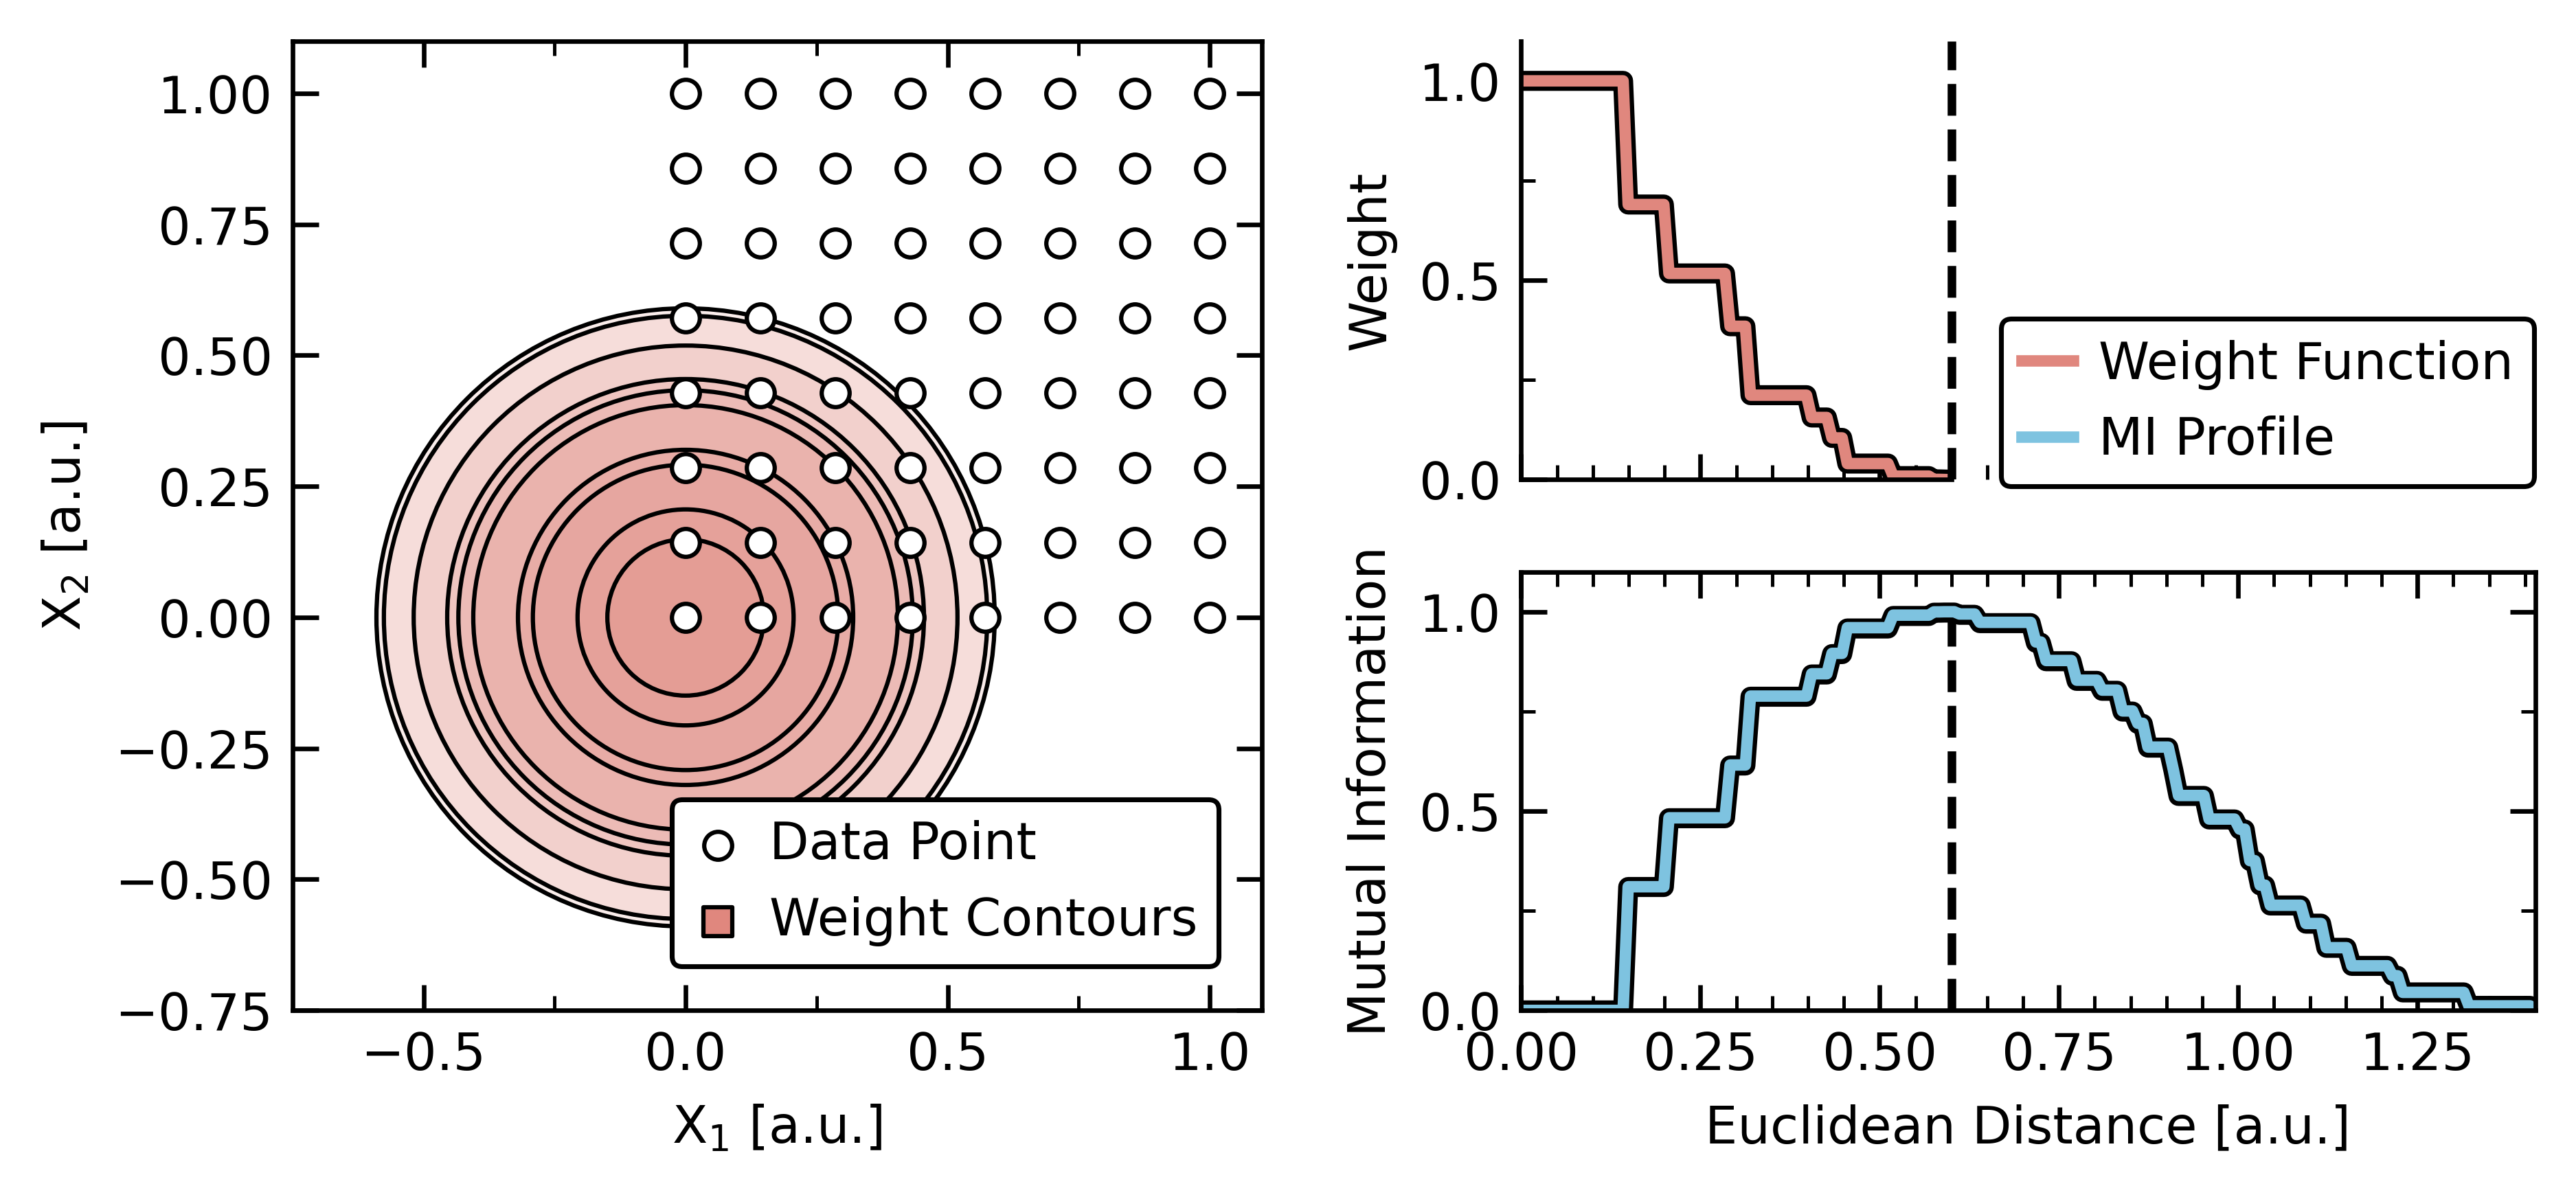

In [12]:
# Create figure
fig = plt.figure(figsize=(6.5, 3), dpi=600)

# Create grid specification
gs = gridspec.GridSpec(2, 2, figure=fig)

# Create axes with the left plot spanning both rows
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Plot on the left axis (spanning both rows)
ax1.scatter(X[:, 0], X[:, 1], fc="w", ec="k", marker=".", s=95, label="Data Point", zorder=5, lw=0.75)
ax1.scatter([],[], marker='s', fc='#E0877E', ec='k', s=25, lw=0.75, label='Weight Contours')

radii_indices = [np.argmin(np.abs(weight_function - value)) for value in [0.0, 0.001, 0.01, 0.05, 0.1, 0.15, 0.25, 0.35, 0.5, 0.75, 1.0]]
radii = [x[i] for i in radii_indices]

pt = 0
for rad in radii:
    circle = plt.Circle((X[pt, 0], X[pt, 1]), rad, color="#E0877E", ls='-', alpha=0.15, fill=True, ec="none")
    ax1.add_artist(circle)
for rad in radii:
    edge = plt.Circle((X[pt, 0], X[pt, 1]), rad, color="k", lw=0.75, ls='-', alpha=1.0, fill=False)
    ax1.add_artist(edge)

ax1.set_aspect('equal')
ax1.set_xlim(-0.75, 1.1)
ax1.set_ylim(-0.75, 1.1)
ax1.set_xlabel("X$_\mathrm{1}$ [a.u.]")
ax1.set_ylabel("X$_\mathrm{2}$ [a.u.]")
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

legend = ax1.legend(frameon=True, framealpha=1, edgecolor="k", loc='lower right')
legend.get_frame().set_linewidth(0.85)

ax2.plot(x[mask], weight_function[mask], lw=3.5, color="k", zorder=1)
ax2.plot(x[mask], weight_function[mask], lw=2, color="#E0877E", zorder=2)

ax2.axvline(cutoff+0.01, color="k", lw=1.5, ls="--")
ax2.set_xlabel("Distance [a.u.]")
ax2.set_ylabel("Weight")
ax2.set_xlim(0, np.max(X_dm))
ax2.set_ylim(0.0, 1.1)
ax2.set_yticks([0, 0.5, 1])

#turn of top axis and right axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.spines['bottom'].set_bounds(0, cutoff+0.01)
ax2.set_xticks([])
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

ax2.plot([],[], color='#E0877E', label="Weight Function")
ax2.plot([],[], color='#7EC3E0', label="MI Profile")
legend = ax2.legend(frameon=True, framealpha=1, edgecolor="k", loc='lower left', bbox_to_anchor=(0.43, -0.115))
legend.get_frame().set_linewidth(0.85)

# Plot on the top right axis
ax3.vlines(cutoff+0.01, 0.0, 1.0, color="k", lw=1.5, ls="--")
ax3.plot(x, mi_profile, lw=3.5, color="k")
ax3.plot(x, mi_profile/np.max(mi_profile), color="#7EC3E0", lw=2)
ax3.set_ylabel("Mutual Information")
ax3.set_xlim(0, np.max(X_dm))
ax3.set_ylim(0, 1.1)
ax3.set_yticks([0, 0.5, 1])
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

# Share x-axis between the right plots
ax2.sharex(ax3)
# Remove x-tick labels from the top plot since they're shared
ax2.tick_params(axis='x', labelbottom=False)
# Move x-label to the bottom plot
ax2.set_xlabel('')
ax3.set_xlabel("Euclidean Distance [a.u.]")

plt.tight_layout()
plt.show()